<a href="https://colab.research.google.com/github/protyush121/netflix-clone/blob/master/Deep_Learning_with_PyTorch_ImageSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1 : Set up colab gpu runtime environment

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-whhz0n3v
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-whhz0n3v
  Resolved https://github.com/albumentations-team/albumentations to commit cb372736a0b7da362e5c2e23f3cce4304ddac402
  Preparing metadata (setup.py) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 MB 13.1 MB/s eta 0:00:00
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.6.0.66
    Uninstalling opencv-contrib-python-4.6.0.66:
      Successfully uninstalled opencv-contrib-python-4.6.0.66


# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [2]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

fatal: destination path 'Human-Segmentation-Dataset-master' already exists and is not an empty directory.


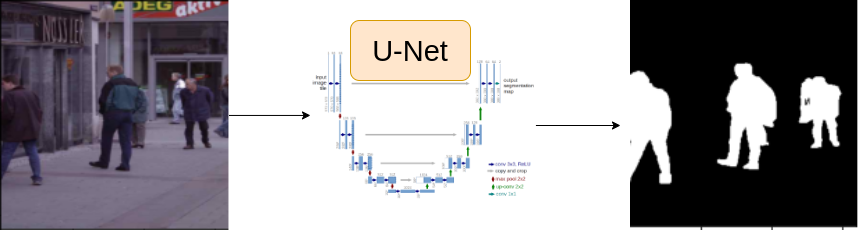

# Some Common Imports

In [3]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [4]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [20]:
CSV_FILE ='/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR ='/content/'
DEVICE ='cuda'
EPOCHS = 25
LR =0.003
IMG_SIZE = 320
BATCH_SIZE=16
ENCODER ='timm-efficientnet-b0'
WEIGHTS ='imagenet'

In [6]:
df = pd.read_csv (CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [7]:
row = df.iloc[0]
image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path , cv2.IMREAD_GRAYSCALE) / 255.0

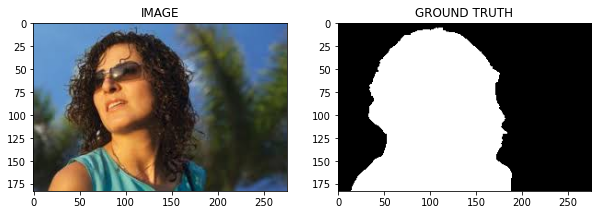

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [9]:
train_df,valid_df = train_test_split(df,test_size=0.2 , random_state=42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [26]:
from torch.utils.data import Dataset

In [27]:
class SegmentationDataset(Dataset):
  def __init__(self,df, augmentations):
    self.df=df
    self.augmentations = augmentations 
  def __len__(self):
    return len(self.df)
  def __getitem__(self ,idx):
    row = self.df.iloc[idx]
    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path , cv2.IMREAD_GRAYSCALE) #(h,w,c)
    mask =np.expand_dims(mask ,axis=-1)

    if self.augmentations :
      data =self.augmentations(image = image , mask = mask)
      image = data['image']
      mask = data ['mask']

    #(h,w,c) -> (c,h,w)
    image = np.transpose(image ,(2,0,1)).astype(np.float32)
    mask = np.transpose(mask ,(2,0,1)).astype(np.float32)

    image = torch.Tensor(image)/255.0
    mask = torch.round(torch.Tensor(mask)/255.0)

    return image,mask

# Task 4 : Create Custom Dataset 

In [28]:
from torch.utils.data import Dataset

In [14]:
trainset = SegmentationDataset(train_df , get_train_augs())
validset = SegmentationDataset(valid_df , get_valid_augs())

In [15]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


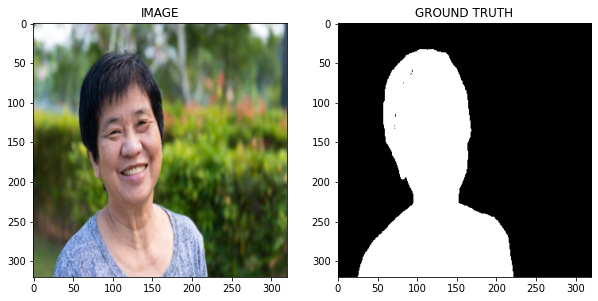

In [16]:
idx = 3
image ,mask = trainset[idx]
helper.show_image(image , mask)

# Task 5 : Load dataset into batches

In [17]:
from torch.utils.data import DataLoader

In [21]:
trainloader = DataLoader(trainset , batch_size =BATCH_SIZE , shuffle =True )
validloader = DataLoader(validset , batch_size =BATCH_SIZE  )

In [22]:
print(f"total no,of batches in trainloader: {len(trainloader)}")
print(f"total no,of batches in validloader: {len(validloader)}")

total no,of batches in trainloader: 15
total no,of batches in validloader: 4


In [30]:
for image, mask in trainloader:
  break

print(f"One batch image shape : {image.shape}")
print(f"One batch mask shape : {mask.shape}")

ValueError: ignored

# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [31]:

! pip install segmentation_models_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [32]:
from torch import nn 
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [33]:
class SegmentationModel (nn.Module):

  def __init__(self):
    super (SegmentationModel , self).__init__()
    
    self.arc = smp.Unet(
        encoder_name= ENCODER ,
        encoder_weights=  WEIGHTS ,
        in_channels= 3 ,
        classes=  1 ,
        activation = None
    )
  def forward (self ,images ,masks = None):
    logits = self.arc(images)
    
    if masks != None :
      loss1 = DiceLoss(mode='binary')(logits , masks)
      loss2 = nn.BCEWithLogitsLoss()(logits , masks)
      return logits , loss1+loss2
    return logits

In [34]:
model = SegmentationModel()
model.to(DEVICE)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0_aa-827b6e33.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0_aa-827b6e33.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
           

# Task 7 : Create Train and Validation Function 

In [35]:
def train_fn(data_loader, model, optimizer):

  model.train()
  total_loss=0.0
  for images, masks in tqdm(data_loader):

    images=images.to (DEVICE)

    masks=masks.to(DEVICE)

    optimizer.zero_grad() 
    logits, loss=model (images, masks)

    loss.backward() 
    optimizer.step()

    total_loss+= loss.item()

  return total_loss / len(data_loader)

In [36]:
def eval_fn(data_loader, model):

  model.eval()
  total_loss=0.0
  with torch.no_grad():
    for images, masks in tqdm(data_loader):

      images=images.to (DEVICE)

      masks=masks.to(DEVICE)

    
      logits, loss=model (images, masks)

      loss.backward() 
    

      total_loss+= loss.item()

    return total_loss / len(data_loader)

# Task 8 : Train Model

In [37]:
 optimizer= torch.optim. Adam (model.parameters(), lr = LR)

In [38]:
best_valid_loss = np.Inf 
for i in range (EPOCHS):

  train_loss = train_fn(trainloader, model, optimizer) 
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_valid_loss:

    torch.save(model.state_dict(), 'best model.pt') 
    print("SAVED MODEL")

    best_valid_loss = valid_loss

  print (f"Epoch: (i+1) Train loss: (train_loss) Valid loss: {valid_loss}")

  0%|          | 0/15 [00:00<?, ?it/s]


ValueError: ignored

# Task 9 : Inference

In [39]:
idx = 20

model.load_state_dict (torch.load('/content/best model..pt'))

image, mask = validset[idx]

logits_mask = model (image. to (DEVICE).unsqueeze (0)) # (C, H, W) (1, C, H, W)

pred_mask= torch.sigmoid (logits_mask)

pred_mask =(pred_mask> 0.5)*1.0

FileNotFoundError: ignored

In [40]:
helper.show_image (image, mask, pred_mask.detach().cpu().squeeze(0))

NameError: ignored

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya